1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

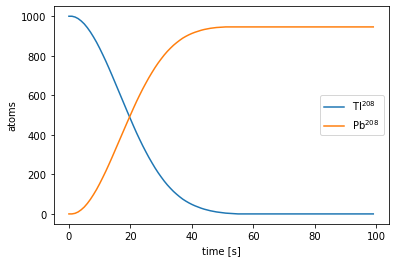

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy import integrate

nsteps = 100
nTl = np.array([1000,])
nPb = np.array([0,])
def p(t):
    return 1 - 2**(-t/(60*3.052))
time = np.arange(0, nsteps)
for i, t in zip(range(nsteps -1), time):
    nTl = np.append(nTl, int(nTl[i]*(1 - p(t))))
    nPb = np.append(nPb, nPb[i]+int(nTl[i]*p(t)))
plt.plot(time, nTl, label='Tl$^{208}$')
plt.plot(time, nPb, label='Pb$^{208}$')
plt.xlabel('time [s]')
plt.ylabel('atoms')
plt.legend(loc='best')

Text(0, 0.5, '$Tl^{208}$ atoms')

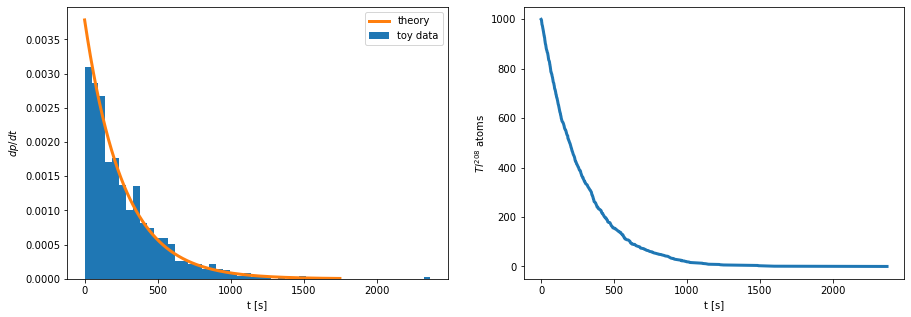

In [2]:
def inv_cdf(rnd):
    tau = 60*3.052
    return tau*np.log2(np.e)*np.log(1/(1 - rnd))
def p(t):
    tau = 60*3.052
    return 2**(-t/tau)*np.log(2)/tau

natoms = 1000
r_sample = np.random.rand(natoms)
times = inv_cdf(r_sample)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
histo = ax[0].hist(times, bins=50, density=True, label='toy data')
t = np.arange(1750)
ax[0].plot(t, p(t), label='theory', lw=3)
ax[0].legend(loc='best')
ax[0].set_xlabel('t [s]')
ax[0].set_ylabel('$dp/dt$')

decay_times, freq = np.unique(np.sort(times), return_counts=True)
survivals = natoms - np.cumsum(freq)
ax[1].plot(decay_times, survivals, lw=3)
ax[1].set_xlabel('t [s]')
ax[1].set_ylabel('$Tl^{208}$ atoms')


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

**Remark**: If we measure lenghts in units of $a_0$ and we introduce the value for the Bohr energy $|E_B| = \frac{e^2}{8\pi\epsilon_0 a_0} = 13.6 \,\,eV$, we can write
$$
\tan(\theta/2) = \frac{4 Z E_B}{E b}
$$

In [3]:
from numpy.linalg import norm
nparicles = 10**6
sigma = 1/100
particles = np.random.multivariate_normal([0,0], [[sigma**2, 0], [0, sigma**2]], nparicles)
b = norm(particles, axis=1)
def tan_theta(b):
    Z = 79
    E = 7.7e6
    E_b = 13.6
    return 4*Z*E_b/(E*b)
frac = len(b[tan_theta(b) > 1])/len(b)
print('Particle that bounces back: {:.2f} %'.format(frac * 100))

Particle that bounces back: 0.16 %


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [13]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2
N = 100000
def hit_or_miss_MC(f, V, N):
    count = 0
    for i in range(N):
        x = V*np.random.rand()
        y = np.random.rand()
        if y < f(x):
            count += 1
    return 2*count/N
area = hit_or_miss_MC(f, V, N)
print('Monte Carlo integral value:', area)
bound1, bound2 = 1e-9, 2-1e-9
x = np.linspace(bound1,bound2,100000)
true_area = integrate.trapz(f(x), x)
print('Trapz integral value:', true_area)
print('Error:', np.abs((area - true_area)/ true_area)*100, '%')

Monte Carlo integral value: 1.4547
Trapz integral value: 1.451521409672071
Error: 0.21898335820256482 %


In [14]:
V = 2
N = 100000
def mean_value_MC(f, V, N):
    x = V*np.random.rand(N)
    return V/N * np.sum(f(x))
mean_value_integral = mean_value_MC(f, V, N)
print('Mean-value Monte Carlo integral:', mean_value_integral)
print('Error:', np.abs((mean_value_integral - true_area)/ true_area)*100, '%')

Mean-value Monte Carlo integral: 1.4527558043609599
Error: 0.08504143863559945 %


Hit or miss dev_std: 0.13858796936527126
Mean-value dev_std: 0.08105017017448615


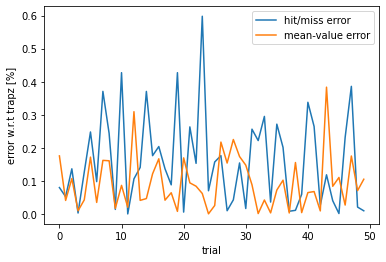

In [18]:
# Comparison between the two Monte Carlo methods with respect to the trapz integral
def error(area, true_area):
    return np.abs((area - true_area)/ true_area)*100
ntrials = 50
trials = np.arange(ntrials)
hm_MC_err = np.array([])
mv_MC_err = np.array([])
for _ in range(ntrials):
    hm_MC_err = np.append(hm_MC_err, error(hit_or_miss_MC(f, V, N), true_area))
    mv_MC_err = np.append(mv_MC_err, error(mean_value_MC(f, V, N), true_area))
plt.plot(trials, hm_MC_err, label='hit/miss error')
plt.plot(trials, mv_MC_err, label='mean-value error')
plt.xlabel('trial')
plt.ylabel('error w.r.t trapz [%]')
plt.legend(loc='best')
print('Hit or miss dev_std:', np.std(hm_MC_err))
print('Mean-value dev_std:', np.std(mv_MC_err))

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [35]:
import math
import scipy.special
def f(X):
    test = np.sum(X**2, axis=1) <= 1
    result = np.array([])
    for t in test:
        if t:
            result = np.append(result, 1)
        else:
            result = np.append(result, 0)
    return result
def mv_MC(f, N, bounds, ndim):
    X = np.random.rand(N, ndim)*(bounds[1]-bounds[0]) + bounds[0]
    V = (bounds[1] - bounds[0])**ndim
    return V/N*np.sum(f(X))
def hypersphere_volume(r, ndim): #only even dimensions
    return np.pi**(ndim/2)/math.factorial(ndim/2) * r**ndim

N = 100000
bounds = [-1, 1]
vol2 = mv_MC(f, N, bounds, 2)
vol10 = mv_MC(f, N, bounds, 10)
true_vol2 = hypersphere_volume(1, 2)
true_vol10 = hypersphere_volume(1, 10)
print('2D volume: {}, error: {} %'.format(vol2, np.abs((vol2 - true_vol2)/true_vol2)))
print('10D volume: {}, error: {} %'.format(vol10, np.abs((vol10 - true_vol10)/true_vol10)))

2D volume: 3.1449200000000004, error: 0.0010591272571271193 %
10D volume: 2.5088000000000004, error: 0.0162201486769197 %


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [26]:
c = np.array([[2,3], [4,5]])
print(c**2)

[[ 4  9]
 [16 25]]
